Using device: cuda
Starting training...
Epoch 1/3:
Training Loss: 2.2898
Training Accuracy: 15.40%
Test Accuracy: 89.04%
--------------------------------------------------
Epoch 2/3:
Training Loss: 2.2756
Training Accuracy: 18.29%
Test Accuracy: 92.68%
--------------------------------------------------
Epoch 3/3:
Training Loss: 2.2712
Training Accuracy: 18.73%
Test Accuracy: 93.45%
--------------------------------------------------


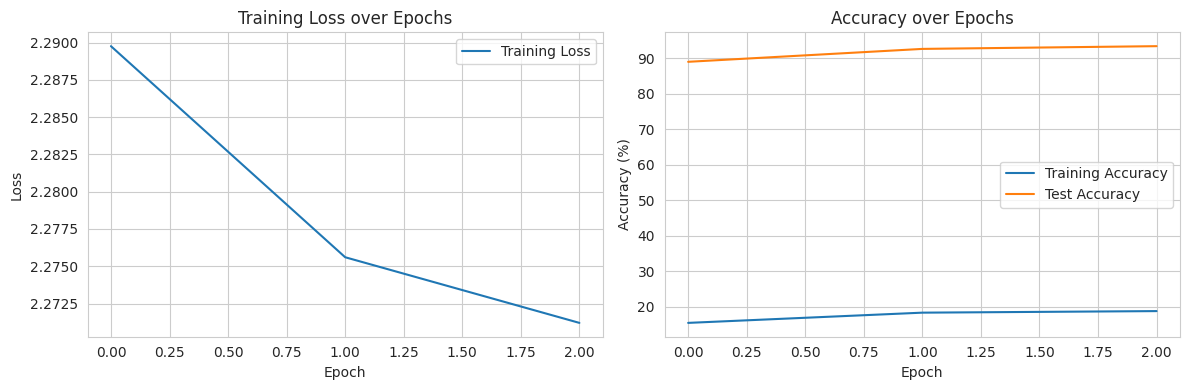

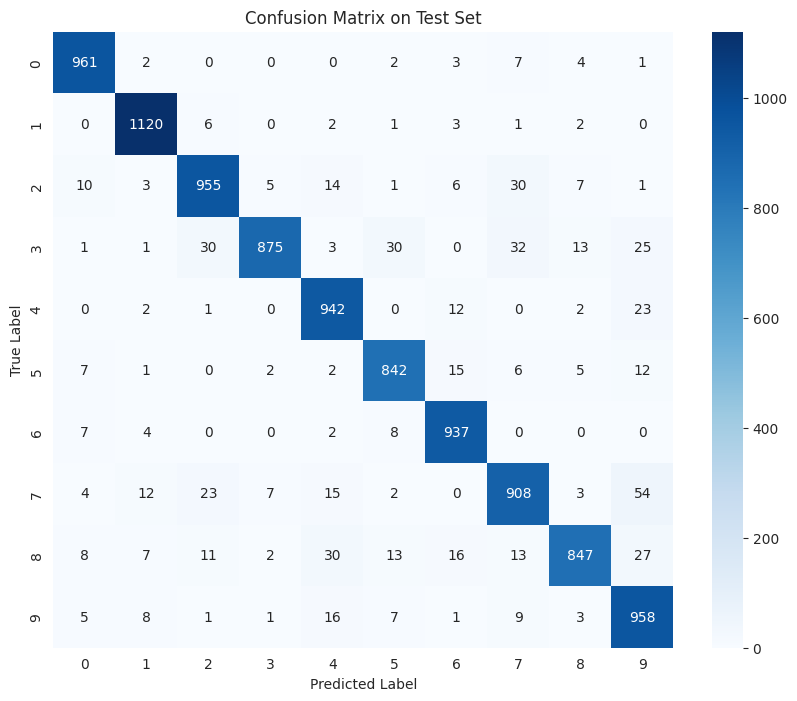

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the neural network architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Custom dataset class to introduce mislabeled data
class MislabeledMNIST(Dataset):
    def __init__(self, dataset, mislabel_ratio):
        self.dataset = dataset
        self.mislabel_ratio = mislabel_ratio
        self.targets = dataset.targets.clone()

        # Randomly select indices to mislabel
        num_samples = len(dataset)
        num_mislabel = int(num_samples * mislabel_ratio)
        mislabel_indices = np.random.choice(num_samples, num_mislabel, replace=False)

        # Generate random wrong labels (ensuring they're different from original)
        for idx in mislabel_indices:
            original_label = self.targets[idx]
            possible_labels = list(range(10))
            possible_labels.remove(original_label)
            new_label = np.random.choice(possible_labels)
            self.targets[idx] = new_label

        # Keep track of which samples are mislabeled
        self.mislabeled_mask = torch.zeros(num_samples, dtype=torch.bool)
        self.mislabeled_mask[mislabel_indices] = True

    def __getitem__(self, index):
        image, _ = self.dataset[index]
        return image, self.targets[index]

    def __len__(self):
        return len(self.dataset)

# Training function
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total

# Load and preprocess data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Create mislabeled training dataset
mislabeled_train_dataset = MislabeledMNIST(train_dataset, mislabel_ratio=0.8)

# Create data loaders
train_loader = DataLoader(mislabeled_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model, criterion, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4) #Shout-out to Andrew Karpathy

# Training loop
num_epochs = 3
train_losses = []
train_accuracies = []
test_accuracies = []

print("Starting training...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Training Accuracy: {train_acc:.2f}%')
    print(f'Test Accuracy: {test_acc:.2f}%')
    print('-' * 50)

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Generate confusion matrix on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()